In [1]:
# !pip install -i https://test.pypi.org/simple/ PPandas==0.0.1.6.7
!pip install pgmpy==0.1.9
!pip install networkx==2.4
!pip install matplotlib
!pip install python-intervals

In [2]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from ppandas import PDataFrame
import pandas as pd

## Data Preparation

In [3]:
# Load census data
census = pd.read_csv("neighbourhood-profiles-2016.csv", skipinitialspace=True) 
census.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


In [4]:
census.columns.to_list()

['_id',
 'Category',
 'Topic',
 'Data Source',
 'Characteristic',
 'City of Toronto',
 'Agincourt North',
 'Agincourt South-Malvern West',
 'Alderwood',
 'Annex',
 'Banbury-Don Mills',
 'Bathurst Manor',
 'Bay Street Corridor',
 'Bayview Village',
 'Bayview Woods-Steeles',
 'Bedford Park-Nortown',
 'Beechborough-Greenbrook',
 'Bendale',
 'Birchcliffe-Cliffside',
 'Black Creek',
 'Blake-Jones',
 'Briar Hill-Belgravia',
 'Bridle Path-Sunnybrook-York Mills',
 'Broadview North',
 'Brookhaven-Amesbury',
 'Cabbagetown-South St. James Town',
 'Caledonia-Fairbank',
 'Casa Loma',
 'Centennial Scarborough',
 'Church-Yonge Corridor',
 'Clairlea-Birchmount',
 'Clanton Park',
 'Cliffcrest',
 'Corso Italia-Davenport',
 'Danforth',
 'Danforth East York',
 'Don Valley Village',
 'Dorset Park',
 'Dovercourt-Wallace Emerson-Junction',
 'Downsview-Roding-CFB',
 'Dufferin Grove',
 'East End-Danforth',
 'Edenbridge-Humber Valley',
 'Eglinton East',
 'Elms-Old Rexdale',
 'Englemount-Lawrence',
 'Eringate-Ce

In [5]:
census['Topic'].unique()

array(['Neighbourhood Information', 'Population and dwellings',
       'Age characteristics', 'Household and dwelling characteristics',
       'Marital status', 'Family characteristics', 'Household type',
       'Family characteristics of adults',
       'Knowledge of official languages',
       'First official language spoken', 'Mother tongue',
       'Knowledge of languages', 'Income of households in 2015',
       'Language spoken most often at home',
       'Income of individuals in 2015',
       'Other language spoken regularly at home', 'Low income in 2015',
       'Income of economic families in 2015',
       'Immigrants by selected place of birth', 'Citizenship',
       'Visible minority population',
       'Immigrant status and period of immigration',
       'Ethnic origin population', 'Age at immigration',
       'Aboriginal population', 'Highest certificate, diploma or degree',
       'Recent immigrants by selected place of birth',
       'Generation status', 'Admission categ

In [6]:
# Get relevant columns from census data
# Only use Income of Individual
# Assume <$40K is "low income"
cols = ['Under $10,000 (including loss)',
        '$10,000 to $19,999','$20,000 to $29,999','$30,000 to $39,999','$40,000 to $49,999',
        '$50,000 to $59,999','$60,000 to $69,999','$70,000 to $79,999','$80,000 to $89,999',
        '$90,000 to $99,999','$100,000 and over']
census['Characteristic'] = census['Characteristic'].str.strip()
filt_census = census[census['Topic'].str.contains("Income of ind") & census['Characteristic'].isin(cols)]
filt_census = filt_census.drop_duplicates(subset ="Characteristic", keep = 'first')
filt_census["is_low_income"] = filt_census['Characteristic'].isin(cols[:4])
filt_census["is_low_income"] = filt_census["is_low_income"].replace({True: 'Yes', False: 'No'})
filt_census = filt_census.drop(['_id', 'Category', 'Topic', 'Data Source', 'City of Toronto','Characteristic'], axis=1)

filt_census[filt_census.columns.to_list()[:-1]] = filt_census[filt_census.columns.to_list()[:-1]].replace(',','', regex=True).astype(int)
filt_census = filt_census.groupby(['is_low_income']).sum()
filt_census = filt_census.unstack().reset_index()
filt_census.columns = ["neighbourhood_clean","is_low_income","count"]
filt_census['neighbourhood_clean'] = filt_census['neighbourhood_clean'].str.lower()
filt_census['neighbourhood_clean'] = filt_census['neighbourhood_clean'].str.replace(r'[^a-z ]', '')
filt_census['neighbourhood_clean'] = filt_census['neighbourhood_clean'].str.strip()

filt_census.head()


,neighbourhood_clean,is_low_income,count
0,agincourt north,No,5725
1,agincourt north,Yes,17480
2,agincourt southmalvern west,No,5095
3,agincourt southmalvern west,Yes,13775
4,alderwood,No,4085


In [7]:
# Load Yelp Business data
yelp_businesses = pd.read_csv("businesses.csv", skipinitialspace=True) 
yelp_businesses.head()

C:\Users\mkiri\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,advertiser,alias,appointment,attrs,categories_academic,categories_scrape,claimed,coordinates,display_phone,...,rating_academic,rating_scrape,related,review_count_academic,review_count_scrape,transactions,url,neighbourhood_official,longitude,latitude
0,0,NaN,sleep-country-toronto,False,"{'Accepts Apple Pay': 'No', 'Bike Parking': 'Y...","[{'alias': 'mattresses', 'title': 'Mattresses'...","['Mattresses', 'Furniture Stores']",True,"{'latitude': 43.66205, 'longitude': -79.38597}",+1 416-642-1180,...,2.5,2.5,['/biz/roche-bobois-toronto?page_src=related_b...,3,3.0,[],https://www.yelp.com/biz/sleep-country-toronto...,Bay Street Corridor (76),-79.385970,43.662050
1,1,NaN,pest-solution-services-toronto,False,NaN,"[{'alias': 'homecleaning', 'title': 'Home Clea...",['Pest Control'],False,"{'latitude': 43.7495489, 'longitude': -79.5807...",+1 416-451-7659,...,5.0,5.0,NaN,1,2.0,[],https://www.yelp.com/biz/pest-solution-service...,Mount Olive-Silverstone-Jamestown (2),-79.580750,43.749549
2,2,NaN,ccim-central-canada-toronto,False,NaN,"[{'alias': 'social_clubs', 'title': 'Social Cl...",['Social Clubs'],False,"{'latitude': 43.66528, 'longitude': -79.40358}",+1 416-244-0435,...,5.0,5.0,NaN,1,1.0,[],https://www.yelp.com/biz/ccim-central-canada-t...,University (79),-79.403580,43.665280
3,3,NaN,happy-lemon-markham,False,"{'Take-out': 'Yes', 'Accepts Apple Pay': 'No',...","[{'alias': 'bubbletea', 'title': 'Bubble Tea'}...","['Bubble Tea', 'Coffee & Tea']",True,"{'latitude': 43.8258200636421, 'longitude': -7...",+1 416-855-0768,...,3.5,3.5,['/biz/pop-up-house-markham?page_src=related_b...,32,33.0,[],https://www.yelp.com/biz/happy-lemon-markham?a...,NaN,-79.306346,43.825820
4,4,NaN,finch-go-bus-terminal-toronto,False,NaN,"[{'alias': 'publictransport', 'title': 'Public...",['Public Transportation'],False,"{'latitude': 43.78268, 'longitude': -79.4158}",NaN,...,2.5,2.5,NaN,7,7.0,[],https://www.yelp.com/biz/finch-go-bus-terminal...,Newtonbrook East (50),-79.415800,43.782680


In [8]:
# Which columns are most frequently populated and should be used?
yelp_businesses.isna().sum()

Unnamed: 0                    0
advertiser                30853
alias                         0
appointment                  84
attrs                     12149
categories_academic           0
categories_scrape            67
claimed                      67
coordinates                   0
display_phone              1538
from_owner_images         19347
from_owner_text           19347
hours                     10265
id                            0
image_url                  7023
is_closed                     0
location                      0
name_academic                 0
name_scrape                 718
phone                      1538
price_academic                0
price_scrape              14119
rating_academic               0
rating_scrape               969
related                    8513
review_count_academic         0
review_count_scrape         441
transactions                  0
url                           0
neighbourhood_official     7104
longitude                    71
latitude

In [9]:
a = yelp_businesses['neighbourhood_official'].astype('str').unique()
sorted(a)

['Agincourt North (129)',
 'Agincourt South-Malvern West (128)',
 'Alderwood (20)',
 'Annex (95)',
 'Banbury-Don Mills (42)',
 'Bathurst Manor (34)',
 'Bay Street Corridor (76)',
 'Bayview Village (52)',
 'Bayview Woods-Steeles (49)',
 'Bedford Park-Nortown (39)',
 'Beechborough-Greenbrook (112)',
 'Bendale (127)',
 'Birchcliffe-Cliffside (122)',
 'Black Creek (24)',
 'Blake-Jones (69)',
 'Briar Hill-Belgravia (108)',
 'Bridle Path-Sunnybrook-York Mills (41)',
 'Broadview North (57)',
 'Brookhaven-Amesbury (30)',
 'Cabbagetown-South St.James Town (71)',
 'Caledonia-Fairbank (109)',
 'Casa Loma (96)',
 'Centennial Scarborough (133)',
 'Church-Yonge Corridor (75)',
 'Clairlea-Birchmount (120)',
 'Clanton Park (33)',
 'Cliffcrest (123)',
 'Corso Italia-Davenport (92)',
 'Danforth (66)',
 'Danforth East York (59)',
 'Don Valley Village (47)',
 'Dorset Park (126)',
 'Dovercourt-Wallace Emerson-Junction (93)',
 'Downsview-Roding-CFB (26)',
 'Dufferin Grove (83)',
 'East End-Danforth (62)',
 

In [10]:
# Get relevant columns from Yelp business data
yelp_businesses_filt = yelp_businesses.loc[yelp_businesses['neighbourhood_official'].notnull(),['id','name_academic','neighbourhood_official']]
yelp_businesses_filt['neighbourhood_clean'] = yelp_businesses_filt.loc[:,['neighbourhood_official']]
yelp_businesses_filt['neighbourhood_clean'] = yelp_businesses_filt['neighbourhood_clean'].str.lower()
yelp_businesses_filt['neighbourhood_clean'] = yelp_businesses_filt['neighbourhood_clean'].str.replace(r'[^a-z ]', '')
yelp_businesses_filt['neighbourhood_clean'] = yelp_businesses_filt['neighbourhood_clean'].str.strip()
yelp_businesses_filt.head()

,id,name_academic,neighbourhood_official,neighbourhood_clean
0,bSQGCheX1BwvL67Az1OJlA,Sleep Country,Bay Street Corridor (76),bay street corridor
1,Z7JV11GXw_RsGr8Ik_Hsag,Pest Solution Services,Mount Olive-Silverstone-Jamestown (2),mount olivesilverstonejamestown
2,kI7ObOAe-Wvjdtnv-8Cu7w,Ccim Central Canada,University (79),university
4,83V1E_ePwuLMW5EI40fIBQ,Finch GO Bus Terminal,Newtonbrook East (50),newtonbrook east
7,oRRCe6RruoHE1nMfTlMREA,Black Goat Cafe,Long Branch (19),long branch


In [11]:
# Load Yelp reviews data
yelp_reviews = pd.read_csv("reviews.csv", skipinitialspace=True) 
yelp_reviews.head()

,Unnamed: 0,Unnamed: 0.1,business_id,friend_count,ghost,img_dsc,img_url,nr,photo_count,rating,...,review_language,review_text,ufc,user_id,user_loc,vote_count,Updated,Year,Month,Day
0,0,0,bSQGCheX1BwvL67Az1OJlA,90,False,[],[],False,231.0,5.0,...,en,I had a good experience at this store. I was g...,"[10, 1, 10]",q41qqkChL9fRxF43cnkgbw,"Houston, TX",11.0,False,2018,5,9
1,1,1,bSQGCheX1BwvL67Az1OJlA,0,False,[],[],False,9.0,1.0,...,en,I reaaaaaally wish I had read all the stories ...,"[0, 0, 0]",tNT5I9-QcljS-7w_doXCXQ,"Toronto, Canada",0.0,False,2018,6,3
2,2,2,bSQGCheX1BwvL67Az1OJlA,52,False,"[""Photo of Sleep Country - Toronto, ON, Canada...",['https://s3-media1.fl.yelpcdn.com/bphoto/E_gL...,False,27.0,1.0,...,en,Everything was fine until the delivery. I wait...,"[3, 1, 2]",9q1Do6TVM27RNHUQAQxPRg,"Toronto, Canada",3.0,False,2016,30,7
3,3,3,Z7JV11GXw_RsGr8Ik_Hsag,0,False,[],[],False,NaN,5.0,...,en,"Thought I had bed bugs, but it turned out to b...","[0, 0, 0]",cr-4gAf1_seYWLoO59Lp4w,"Old Toronto, Toronto, Canada",0.0,False,2018,16,12
4,4,4,Z7JV11GXw_RsGr8Ik_Hsag,0,False,[],[],False,NaN,5.0,...,en,"When we called, Mr. Akram was willing to come ...","[1, 0, 0]",CQkTIyhNczRlRI4kIdAzSw,"Toronto, Canada",1.0,False,2014,6,8


In [12]:
# Which columns are most frequently populated and should be used?
yelp_reviews.isna().sum()

Unnamed: 0              0
Unnamed: 0.1            0
business_id             0
friend_count            0
ghost                   0
img_dsc                 0
img_url                 0
nr                      0
photo_count        341311
rating                  0
review_count            0
review_date             0
review_id               0
review_language         1
review_text             2
ufc                   260
user_id            205860
user_loc              110
vote_count         206145
Updated                 0
Year                    0
Month                   0
Day                     0
dtype: int64

In [13]:
# Get relevant columns from Yelp reviews data
# Only include 2016 data (census is from 2016)
yelp_reviews_filt = yelp_reviews.loc[yelp_reviews['Year']==2016, ['business_id', 'review_text']]
yelp_reviews_filt['review_text'] = yelp_reviews_filt['review_text'].str.lower()
yelp_reviews_filt['mentions_money'] = yelp_reviews_filt['review_text'].str.contains('money')

In [14]:
# Combine Yelp business and reviews data
yelp = yelp_businesses_filt.merge(yelp_reviews_filt, left_on='id', right_on='business_id')
yelp = yelp.drop(['business_id','neighbourhood_official','id','name_academic','review_text'],axis=1)
yelp.head()

,neighbourhood_clean,mentions_money
0,bay street corridor,True
1,newtonbrook east,False
2,long branch,False
3,long branch,False
4,long branch,False


In [15]:
print(yelp_businesses_filt['id'].count())
print(yelp_reviews_filt['business_id'].count())
print(yelp['mentions_money'].count())

25019
125188
102009


In [16]:
print(yelp['mentions_money'].value_counts())

False    98126
True      3883
Name: mentions_money, dtype: int64


## ppandas

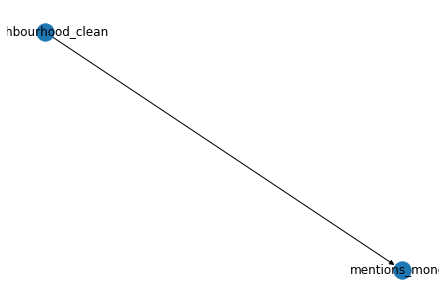

+--------------------------------------------------------+-------------+
| neighbourhood_clean(agincourt north)                   | 0.00266643  |
+--------------------------------------------------------+-------------+
| neighbourhood_clean(agincourt southmalvern west)       | 0.00857767  |
+--------------------------------------------------------+-------------+
| neighbourhood_clean(alderwood)                         | 0.0019214   |
+--------------------------------------------------------+-------------+
| neighbourhood_clean(annex)                             | 0.0410062   |
+--------------------------------------------------------+-------------+
| neighbourhood_clean(banburydon mills)                  | 0.0114892   |
+--------------------------------------------------------+-------------+
| neighbourhood_clean(bathurst manor)                    | 0.00222529  |
+--------------------------------------------------------+-------------+
| neighbourhood_clean(bay street corridor)         

+--------------------------------------------------------+-------------+
+-----------------------+--------------------------------------+--------------------------------------------------+--------------------------------+----------------------------+---------------------------------------+-------------------------------------+------------------------------------------+--------------------------------------+-------------------------------------------+------------------------------------------+---------------------------------------------+------------------------------+-------------------------------------------+----------------------------------+---------------------------------+------------------------------------------+------------------------------------------------------+--------------------------------------+-----------------------------------------+----------------------------------------------------+----------------------------------------+--------------------------------+-------

+-----------------------+--------------------------------------+--------------------------------------------------+--------------------------------+----------------------------+---------------------------------------+-------------------------------------+------------------------------------------+--------------------------------------+-------------------------------------------+------------------------------------------+---------------------------------------------+------------------------------+-------------------------------------------+----------------------------------+---------------------------------+------------------------------------------+------------------------------------------------------+--------------------------------------+-----------------------------------------+----------------------------------------------------+----------------------------------------+--------------------------------+---------------------------------------------+----------------------------------

In [17]:
# Get PDF for Yelp data
yelp_pdf = PDataFrame(["neighbourhood_clean"],yelp)
yelp_pdf.visualise(show_tables=True)


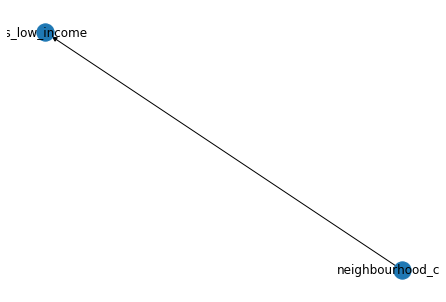

+--------------------------------------------------------+------------+
| neighbourhood_clean(agincourt north)                   | 0.0110814  |
+--------------------------------------------------------+------------+
| neighbourhood_clean(agincourt southmalvern west)       | 0.00901127 |
+--------------------------------------------------------+------------+
| neighbourhood_clean(alderwood)                         | 0.0044937  |
+--------------------------------------------------------+------------+
| neighbourhood_clean(annex)                             | 0.0114945  |
+--------------------------------------------------------+------------+
| neighbourhood_clean(banburydon mills)                  | 0.00996874 |
+--------------------------------------------------------+------------+
| neighbourhood_clean(bathurst manor)                    | 0.00579023 |
+--------------------------------------------------------+------------+
| neighbourhood_clean(bay street corridor)               | 0.010

+--------------------------------------------------------+------------+
+---------------------+--------------------------------------+--------------------------------------------------+--------------------------------+----------------------------+---------------------------------------+-------------------------------------+------------------------------------------+--------------------------------------+-------------------------------------------+------------------------------------------+---------------------------------------------+------------------------------+-------------------------------------------+----------------------------------+---------------------------------+------------------------------------------+------------------------------------------------------+--------------------------------------+-----------------------------------------+-----------------------------------------------------+----------------------------------------+--------------------------------+---------

+---------------------+--------------------------------------+--------------------------------------------------+--------------------------------+----------------------------+---------------------------------------+-------------------------------------+------------------------------------------+--------------------------------------+-------------------------------------------+------------------------------------------+---------------------------------------------+------------------------------+-------------------------------------------+----------------------------------+---------------------------------+------------------------------------------+------------------------------------------------------+--------------------------------------+-----------------------------------------+-----------------------------------------------------+----------------------------------------+--------------------------------+---------------------------------------------+-----------------------------------

In [18]:
# Get PDF for census data

num_records = filt_census[['count']].sum()

census_pdf = PDataFrame.from_populational_data(["neighbourhood_clean"],filt_census,num_records)
census_pdf.visualise(show_tables=True)


In [19]:
# Manually fix neighbourhood names for joining
c = filt_census['neighbourhood_clean'].unique().tolist()
y = yelp['neighbourhood_clean'].unique().tolist()
print(set(c).symmetric_difference(set(y)))

new_values = {"cabbagetownsouth stjames town": "cabbagetownsouth st james town",
              "north stjames town": "north st james town",
              "westonpellam park": "westonpelham park"}
yelp['neighbourhood_clean'] = yelp['neighbourhood_clean'].replace(new_values)

c = filt_census['neighbourhood_clean'].unique().tolist()
y = yelp['neighbourhood_clean'].unique().tolist()
print(set(c).symmetric_difference(set(y)))

joined = filt_census.merge(yelp, how='right', on='neighbourhood_clean', suffixes='_o')
joined[['neighbourhood_clean']].nunique()


{'cabbagetownsouth stjames town', 'cabbagetownsouth st james town', 'north stjames town', 'westonpelham park', 'westonpellam park', 'north st james town'}
set()


neighbourhood_clean    140
dtype: int64

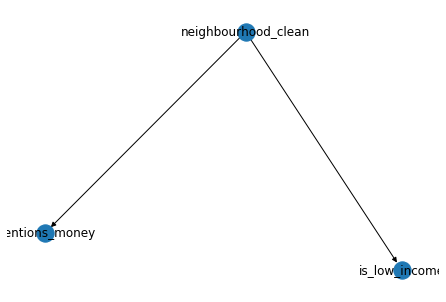

+--------------------------------------------------------+------------+
| neighbourhood_clean(agincourt north)                   | 0.0110814  |
+--------------------------------------------------------+------------+
| neighbourhood_clean(agincourt southmalvern west)       | 0.00901127 |
+--------------------------------------------------------+------------+
| neighbourhood_clean(alderwood)                         | 0.0044937  |
+--------------------------------------------------------+------------+
| neighbourhood_clean(annex)                             | 0.0114945  |
+--------------------------------------------------------+------------+
| neighbourhood_clean(banburydon mills)                  | 0.00996874 |
+--------------------------------------------------------+------------+
| neighbourhood_clean(bathurst manor)                    | 0.00579023 |
+--------------------------------------------------------+------------+
| neighbourhood_clean(bay street corridor)               | 0.010

+--------------------------------------------------------+------------+
+---------------------+--------------------------------------+--------------------------------------------------+--------------------------------+----------------------------+---------------------------------------+-------------------------------------+------------------------------------------+--------------------------------------+-------------------------------------------+------------------------------------------+---------------------------------------------+------------------------------+-------------------------------------------+----------------------------------+---------------------------------+------------------------------------------+------------------------------------------------------+--------------------------------------+-----------------------------------------+-----------------------------------------------------+----------------------------------------+--------------------------------+---------

+---------------------+--------------------------------------+--------------------------------------------------+--------------------------------+----------------------------+---------------------------------------+-------------------------------------+------------------------------------------+--------------------------------------+-------------------------------------------+------------------------------------------+---------------------------------------------+------------------------------+-------------------------------------------+----------------------------------+---------------------------------+------------------------------------------+------------------------------------------------------+--------------------------------------+-----------------------------------------+-----------------------------------------------------+----------------------------------------+--------------------------------+---------------------------------------------+-----------------------------------

+-----------------------+--------------------------------------+--------------------------------------------------+--------------------------------+----------------------------+---------------------------------------+-------------------------------------+------------------------------------------+--------------------------------------+-------------------------------------------+------------------------------------------+---------------------------------------------+------------------------------+-------------------------------------------+----------------------------------+---------------------------------+------------------------------------------+------------------------------------------------------+--------------------------------------+-----------------------------------------+----------------------------------------------------+----------------------------------------+--------------------------------+---------------------------------------------+----------------------------------

In [20]:
# Join census and Yelp data using census distribution
census_yelp_join = census_pdf.pjoin(yelp_pdf)
census_yelp_join.visualise(show_tables=True)

In [31]:
print(census_yelp_join.query(["is_low_income"],evidence_vars={"mentions_money":0}))
print(census_yelp_join.query(["is_low_income"],evidence_vars={"mentions_money":1}))

  is_low_income  Probability(is_low_income)
0            No                    0.374109
1           Yes                    0.625891
  is_low_income  Probability(is_low_income)
0            No                    0.357734
1           Yes                    0.642266


In [32]:
print(census_yelp_join.query(["mentions_money"],evidence_vars={"is_low_income":"Yes"}))
print(census_yelp_join.query(["mentions_money"],evidence_vars={"is_low_income":"No"}))

   mentions_money  Probability(mentions_money)
0             0.0                     0.948696
1             1.0                     0.051304
   mentions_money  Probability(mentions_money)
0             0.0                     0.952025
1             1.0                     0.047975


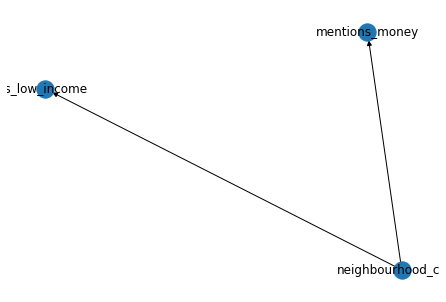

+--------------------------------------------------------+-------------+
| neighbourhood_clean(agincourt north)                   | 0.00266643  |
+--------------------------------------------------------+-------------+
| neighbourhood_clean(agincourt southmalvern west)       | 0.00857767  |
+--------------------------------------------------------+-------------+
| neighbourhood_clean(alderwood)                         | 0.0019214   |
+--------------------------------------------------------+-------------+
| neighbourhood_clean(annex)                             | 0.0410062   |
+--------------------------------------------------------+-------------+
| neighbourhood_clean(banburydon mills)                  | 0.0114892   |
+--------------------------------------------------------+-------------+
| neighbourhood_clean(bathurst manor)                    | 0.00222529  |
+--------------------------------------------------------+-------------+
| neighbourhood_clean(bay street corridor)         

+--------------------------------------------------------+-------------+
+-----------------------+--------------------------------------+--------------------------------------------------+--------------------------------+----------------------------+---------------------------------------+-------------------------------------+------------------------------------------+--------------------------------------+-------------------------------------------+------------------------------------------+---------------------------------------------+------------------------------+-------------------------------------------+----------------------------------+---------------------------------+------------------------------------------+------------------------------------------------------+--------------------------------------+-----------------------------------------+-----------------------------------------------------+----------------------------------------+--------------------------------+------

+-----------------------+--------------------------------------+--------------------------------------------------+--------------------------------+----------------------------+---------------------------------------+-------------------------------------+------------------------------------------+--------------------------------------+-------------------------------------------+------------------------------------------+---------------------------------------------+------------------------------+-------------------------------------------+----------------------------------+---------------------------------+------------------------------------------+------------------------------------------------------+--------------------------------------+-----------------------------------------+-----------------------------------------------------+----------------------------------------+--------------------------------+---------------------------------------------+---------------------------------

+---------------------+--------------------------------------+--------------------------------------------------+--------------------------------+----------------------------+---------------------------------------+-------------------------------------+------------------------------------------+--------------------------------------+-------------------------------------------+------------------------------------------+---------------------------------------------+------------------------------+-------------------------------------------+----------------------------------+---------------------------------+------------------------------------------+------------------------------------------------------+--------------------------------------+-----------------------------------------+----------------------------------------------------+----------------------------------------+--------------------------------+---------------------------------------------+------------------------------------

In [23]:
# Join census and Yelp data using Yelp distribution
census_yelp_join2 = yelp_pdf.pjoin(census_pdf)
census_yelp_join2.visualise(show_tables=True)

In [33]:
print(census_yelp_join2.query(["is_low_income"],evidence_vars={"mentions_money":0}))
print(census_yelp_join2.query(["is_low_income"],evidence_vars={"mentions_money":1}))

  is_low_income  Probability(is_low_income)
0            No                    0.417121
1           Yes                    0.582879
  is_low_income  Probability(is_low_income)
0            No                    0.414257
1           Yes                    0.585743


In [34]:
print(census_yelp_join2.query(["mentions_money"],evidence_vars={"is_low_income":"Yes"}))
print(census_yelp_join2.query(["mentions_money"],evidence_vars={"is_low_income":"No"}))

   mentions_money  Probability(mentions_money)
0             0.0                     0.961755
1             1.0                     0.038245
   mentions_money  Probability(mentions_money)
0             0.0                     0.962186
1             1.0                     0.037814
